# Klasyfikacja raka mózgu - Hubert Jaremko

## Proces przetwarzania danych

### Opis zestawu danych
Cheng, Jun (2017): brain tumor dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.1512427.v5 

Zestaw danych zawiera 3064 obrazów z przewagą T1 pochodzących od 233 pacientów z trzema rodzajami nowotworów mózgu:
 - oponiak (*meningioma*, 708 obrazów), 
 - glejak (*glioma*, 1426 obrazów),
 - nowotwór przysadki (*pituitary tumor*, 930 obrazów).

Dane zostały zorganizowe w formacie matlaba (pliki `.mat`).
Każdy plik przechowuje strukture danych składającą się z następujących pól:
 - `cjdata.label`: `1` oznaczający oponiaka, `2` gelajka, `3` guz przysadki
 - `cjdata.PID`: ID pacjenta
 - `cjdata.image`: dane obrazu
 - `cjdata.tumorBorder`: wektor zawierajacy koordynaty punktów na granicy guza.
 - `cjdata.tumorMask`: obraz binarny, w którym jedynki oznaczają region guza

### Wczytanie obrazów

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
cancer_type = {1 : 'Oponiak', 2 : 'Glejak', 3 : 'Guz przysadki'}

In [7]:
def from_raw_pid(raw_pid):
    return ''.join([chr(c[0]) for c in raw_pid])

def from_raw_label(raw_label):
    return int(raw_label[0][0])

def from_raw(raw):
    return raw[0][0]

def from_raw_image(raw_image):
    return np.asarray(raw_image)

def read_raw_brain_data(index):
    import h5py
    brain_path = f'data/raw/{index}.mat'
    
    with h5py.File(brain_path, 'r') as file:
        # pid = from_raw_pid(list(file['cjdata']['PID']))
        image = from_raw_image(list(file['cjdata']['image']))
        label = from_raw_label(list(file['cjdata']['label']))
        return (image, label)
    return None

In [8]:
# data_amount = 3064
data_amount = 500
start_i = 690
brains_data = [read_raw_brain_data(i) for i in range(start_i, start_i + data_amount)]

In [9]:
def plot_images(columns, rows, data):
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns * rows + 1):
        img = data[i][0].T
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title(cancer_type[data[i][1]], fontsize=20)
        ax.set_yticks([])
        ax.set_xticks([])
        plt.imshow(img, cmap='gray')
    plt.show()

In [10]:
def filter_by_type(t):
    return list(filter(lambda x: x[1] == t, brains_data))

type_1 = filter_by_type(1)
type_2 = filter_by_type(2)
type_3 = filter_by_type(3)
print(f"Type 1 images: {len(type_1)}")
print(f"Type 2 images: {len(type_2)}")
print(f"Type 3 images: {len(type_3)}")

Type 1 images: 19
Type 2 images: 203
Type 3 images: 278


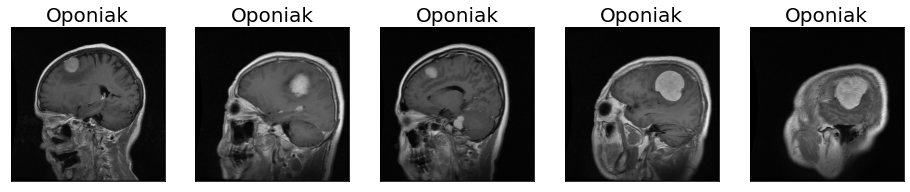

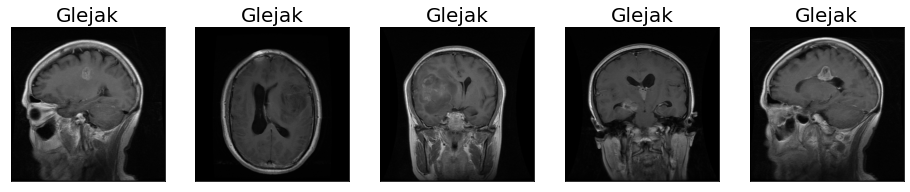

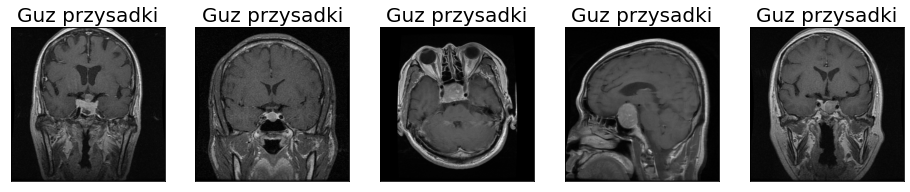

In [11]:
import random

random.shuffle(type_1)
random.shuffle(type_2)
random.shuffle(type_3)

plot_images(5, 1, type_1)
plot_images(5, 1, type_2)
plot_images(5, 1, type_3)

In [12]:
def plot_data_dist(type_1, type_2, type_3):
    df = pd.DataFrame(data={'Zestawy danych': [len(type_1), len(type_2), len(type_3)]}, index=[cancer_type[1], cancer_type[2], cancer_type[3]])
    df.plot(kind='bar', rot=0, legend=None)
    plt.title("Ilość zestawów danych ze wględu na rodzaj guza")
    plt.show()

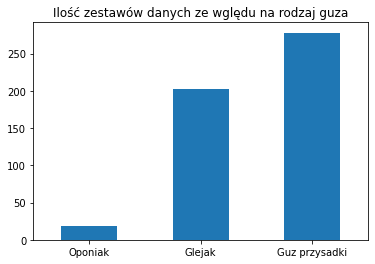

In [13]:
plot_data_dist(type_1, type_2, type_3)

### Preprocessing
Ze względu na duży rozmiar obrazów oraz nierówny rozkład klas nowotworu (zob. wykres) zostaną wykonanne następujące kroki:
- Kompresja oraz przycięcie obrazów do rozmiary 256 $\times$ 256.
- Uzupełnienie brakujących klas nowotwórów przez wzorst danych.

In [14]:
import matplotlib.image as mpimg

In [15]:
for i, img in enumerate(type_1):
    mpimg.imsave(f'data/extracted/1/{i}.jpg', img[0].T, cmap='gray')

for i, img in enumerate(type_2):
    mpimg.imsave(f'data/extracted/2/{i}.jpg', img[0].T, cmap='gray')

for i, img in enumerate(type_3):
    mpimg.imsave(f'data/extracted/3/{i}.jpg', img[0].T, cmap='gray')

In [22]:
# img = mpimg.imread('data/extracted/1/0.jpg')
from os import walk

_, _, type_1_filenames = next(walk('data/extracted/1/'))
_, _, type_2_filenames = next(walk('data/extracted/2/'))
_, _, type_3_filenames = next(walk('data/extracted/3/'))

In [160]:
from PIL import Image

def read_brains(source, filenames, t):
    for filename in filenames:
        image = Image.open(f'data/{source}/{t}/{filename}').convert('L')
        image = image.resize((512,512))
        img = np.array(image)
        # img = mpimg.imread(f'data/extracted/{t}/{filename}')
        brains_data.append((img, t))

In [161]:
brains_data = []

read_brains('extracted', type_1_filenames, 1)
read_brains('extracted', type_2_filenames, 2)
read_brains('extracted', type_3_filenames, 3)

In [162]:

_, _, additional_type_1_filenames = next(walk('data/training/1/'))
_, _, additional_type_2_filenames = next(walk('data/training/2/'))
_, _, additional_type_3_filenames = next(walk('data/training/3/'))

read_brains('training', additional_type_1_filenames, 1)
read_brains('training', additional_type_2_filenames, 2)
read_brains('training', additional_type_3_filenames, 3)


In [163]:
brains = pd.DataFrame(data=brains_data, columns=['image', 'tumor_class'])
print(brains.head())
print(brains.info())
print(brains.describe())

                                               image  tumor_class
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2975 entries, 0 to 2974
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        2975 non-null   object
 1   tumor_class  2975 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.6+ KB
None
       tumor_class
count  2975.000000
mean      2.088739
std       0.804028
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       3.000000


### Dodanie etykiet

In [164]:
X = brains.drop(['tumor_class'], axis=1)
y = brains['tumor_class'].values

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (2975, 1) y.shape: (2975,)


### Pipeline

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

In [35]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [36]:
class Compresser(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

In [37]:
class Augmenter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

In [165]:
# bottle_resized = resize(bottle, (140, 54))

dim = 256

class Flattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # print(X.shape)
        # print(X['image'].values[0].shape)
        # X.info()
        # return X['image'].values[0].flatten()
        # return X.flatten()
        # print(X['image'].tolist())
        # arr = np.array(X['image'].values, dtype=object)
        # if arr.shape != (-1, 512, 512):
        # print(arr.shape)
            # arr = resize(arr, (512, 512))
            # arr = np.resize(arr, (-1, 512, 512))
        # print(arr.shape)
        # return arr
        arr = np.array([resize(x, (dim, dim)) for x in X['image'].values])
        # arr = np.array([x.reshape((len(x),-1)) for x in X['image'].values])
        # arr = np.array([x for x in X['image'].values])
        # print (arr.shape)
        return arr.reshape((-1, dim * dim))
        # return arr.reshape((512, -1))
        # return X
        # arr = np.zeros(shape=(0, 512*512))
        # for x in X['image']:
        #     x = x.flatten()
        #     arr = np.append(x, arr)

        # return arr

        # return X

        # images = X['image'].values
        # n_samples = len(images)
        # data = images.reshape((n_samples, -1))
        # return data

In [39]:
from skimage.transform import resize


class Reshaper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):

        X = np.array([resize(x, (512, 512)) for x in X['image'].values])

        # shapes = {}

        # for img in X:
        #     shapes[img.shape] = 0
            
        # for img in X:
        #     shapes[img.shape] += 1


        # print(shapes)

        return X

In [40]:
from sklearn.preprocessing import StandardScaler

In [57]:
X['image'][0].shape

(512, 512)

In [533]:
# StandardScaler().fit_transform(X)

In [166]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        # ('select_image', DataFrameSelector(['image'])),
        # ("reshape_image", Reshaper()),
        ("flatten_image", Flattener()),
        # ("flatten_image2", Flattener2()),
        # ('scaler', StandardScaler()),
        # ("cat_pipeline", cat_pipeline),
    ])

In [78]:
preprocess_pipeline.fit_transform(X).shape
# np.hstack((xx[0], xx[1]))
# X.values.reshape((49, 512, 512))
# X['image'].to_numpy().shape
# y.shape

# my_list = [[[0,1,2],[0,1,2]],[[0,1,2],[0,1,2]]]
# my_list
# np.array(X['image'].tolist()).shape
# my_np_array = np.array(X)
# my_np_array.shape

(500, 262144)

## Proces modelowania

In [79]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

469    [[0, 0, 1, 10, 10, 15, 18, 11, 25, 26, 22, 26,...
296    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
474    [[0, 0, 0, 3, 3, 4, 8, 14, 16, 21, 23, 19, 19,...
198    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 10, 10, 11, 11...
297    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                             ...                        
106    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
270    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
348    [[0, 0, 1, 4, 3, 3, 5, 7, 10, 12, 17, 21, 19, ...
435    [[0, 0, 1, 3, 3, 4, 6, 7, 9, 11, 12, 12, 14, 1...
102    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: image, Length: 250, dtype: object

In [168]:
# X_train =  np.expand_dims(X_train, axis=1)
print("X.shape: {} y.shape: {}".format(X_train.shape, y_train.shape))

X.shape: (2082, 1) y.shape: (2082,)


In [169]:
seed=123
# kfold = StratifiedKFold(n_splits=5, shuffle=False, random_state=seed)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

In [133]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    # ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear'))])


param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise')
# grid_1 = GridSearchCV(pipe, param_grid, cv=kfold)

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 0.001}

## Porównanie modeli

In [142]:
from sklearn import  metrics

models = []
models.append(('svm_linear', grid_1.best_estimator_))
# models.append(('SVM rbf', grid_2.best_estimator_))
# models.append(('SVM poly', grid_3.best_estimator_))
# models.append(('log reg', grid_4.best_estimator_))

In [143]:
predictions = {}

for name, model in models:
    predictions[name] = model.predict(X_test)

In [144]:
precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    precision_score.append(metrics.precision_score(y_test, predictions[name], average='macro'))
    recall_score.append(metrics.recall_score(y_test, predictions[name], average='macro'))
    f1_score.append( metrics.f1_score(y_test, predictions[name], average='macro'))
    accuracy_score.append(metrics.accuracy_score(y_test, predictions[name]))

In [145]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM linear'])
# df.insert(loc=0, column='Method', value=['SVM linear', 'SVM rbf', 'SVM poly', 'log reg'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,SVM linear,0.994624,0.952381,0.971649,0.993333


## Wizualizacja wyników

Classification report for classifier svm_linear:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.98      1.00      0.99        61
           2       1.00      1.00      1.00        82

    accuracy                           0.99       150
   macro avg       0.99      0.95      0.97       150
weighted avg       0.99      0.99      0.99       150


Confusion matrix:
[[ 6  1  0]
 [ 0 61  0]
 [ 0  0 82]]


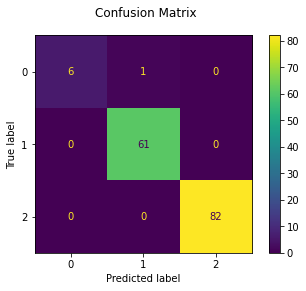

In [146]:
from sklearn import metrics

for name, model in models:
    print(f"Classification report for classifier {name}:\n"
        f"{metrics.classification_report(y_test, predictions[name])}\n")

    disp = metrics.plot_confusion_matrix(model, X_test, y_test)
    disp.figure_.suptitle("Confusion Matrix")
    print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

## Podsumowanie pracy

In [147]:
import joblib
joblib.dump(models[0][1], f'{models[0][0]}.model')

['svm_linear.model']

In [158]:
from PIL import Image
name, model = models[0]
# model = joblib.load('svm_linear.model')


# image = Image.open('image20.jpg').convert('L')
image = Image.open(f'data/extracted/3/1.jpg').convert('L')
img = np.array(image)
# img = X_test['image'][0]
# print(y_test[0])
print(img)

df = pd.DataFrame(data={'image': []})
df.loc[0] = [img]
df
# print(model.predict(X_test.head()))
print(model.predict(df)[0])


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
2


In [150]:
predictions['svm_linear']

array([2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 0, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 1,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1,
       2, 2, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2], dtype=int64)